<a href="https://colab.research.google.com/github/simonEllershaw/3DInfantPoseEstimation/blob/master/transformer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pip transformers torch
# ! pip install -q kaggle

In [2]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# ! kaggle datasets download tboyle10/medicaltranscriptions -p data/
# ! unzip data/clinc150_uci.zip -d data

In [4]:
import json
with open('/content/data/clinc150_uci/data_full.json') as f:
  data = json.load(f)

In [5]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [6]:
data['oos_train'][:10]

[['how much is an overdraft fee for bank', 'oos'],
 ['why are exponents preformed before multiplication in the order of operations',
  'oos'],
 ['what size wipers does this car take', 'oos'],
 ['where is the dipstick', 'oos'],
 ['how much is 1 share of aapl', 'oos'],
 ['how is glue made', 'oos'],
 ['any headlines from my area', 'oos'],
 ['what is the largest state in the us', 'oos'],
 ['what is the current market trend', 'oos'],
 ['what is the most popular airline', 'oos']]

In [7]:
ood_keys = [key for key in data.keys() if 'oos' in key]
data['oos'] = []
for key in ood_keys:
  data['oos'] += data.pop(key)

In [8]:
data['train'][:10]

[['what expression would i use to say i love you if i were an italian',
  'translate'],
 ["can you tell me how to say 'i do not speak much spanish', in spanish",
  'translate'],
 ["what is the equivalent of, 'life is good' in french", 'translate'],
 ["tell me how to say, 'it is a beautiful morning' in italian", 'translate'],
 ['if i were mongolian, how would i say that i am a tourist', 'translate'],
 ["how do i say 'hotel' in finnish", 'translate'],
 ["i need you to translate the sentence, 'we will be there soon' into portuguese",
  'translate'],
 ['please tell me how to ask for a taxi in french', 'translate'],
 ["can you tell me how i would say, 'more bread please' in french",
  'translate'],
 ["what is the correct way to say 'i am a visitor' in french", 'translate']]

In [9]:
data['oos'][:10]

[['set a warning for when my bank account starts running low', 'oos'],
 ['a show on broadway', 'oos'],
 ['who has the best record in the nfl', 'oos'],
 ['how do i find the area of a circle', 'oos'],
 ['how many onions do i have on hand', 'oos'],
 ['what is the name of the 13th president', 'oos'],
 ['show me recent activity in my backyard', 'oos'],
 ['how long will it take me to pay off my card if i pay an extra $50 a month over the minimum',
  'oos'],
 ['does our bank have free notary', 'oos'],
 ['what were the top stories this week', 'oos']]

In [10]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer)

In [11]:
from torch.utils.data import Dataset

class HuggingFaceDataset(Dataset):
  def __init__(self, label2id, tokenizer, texts, labels=None, subset=None):
    self._dict = tokenizer(texts, truncation=True)
    if labels is not None:
      self._dict['labels'] = [label2id[label] for label in labels]

  def __len__(self):
        return len(self._dict["input_ids"])

  def __getitem__(self, idx):
      return {k: v[idx] for k, v in self._dict.items()}

label_names = sorted({label for _, label in data['train']})
id2label = dict(enumerate(sorted(label_names)))
label2id = {v: k for k, v in id2label.items()}

datasets_hf = {}
for key, dataset in data.items():
  texts, labels = map(list,zip(*dataset))
  if labels[0] == 'oos':
    labels = None
  datasets_hf[key] = HuggingFaceDataset(label2id, tokenizer, texts, labels) 

In [12]:
for key, dataset in datasets_hf.items():
  print(key, len(dataset))

val 3000
train 15000
test 4500
oos 1200


(array([1.013e+03, 4.410e+03, 6.366e+03, 2.022e+03, 7.220e+02, 3.610e+02,
        6.800e+01, 3.200e+01, 4.000e+00, 2.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

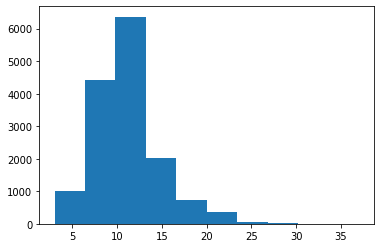

In [13]:
import matplotlib.pyplot as plt
plt.hist([len(sample['input_ids']) for sample in datasets_hf['train']])

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [15]:
from transformers import TrainingArguments

batch_size=32
args = TrainingArguments(
    "inscope_text_classification",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    group_by_length=True,
    warmup_ratio=0.1,
    load_best_model_at_end=True
)


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  """Called to compute validation metrics at each evaluation step of training."""
  logits, labels = eval_pred
  labels = labels.flatten()
  predictions = np.argmax(logits, axis=-1).flatten()

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  metrics = {"f1": f1, "precision": precision, "recall": recall}
  return metrics

In [17]:
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets_hf['train'],
    eval_dataset=datasets_hf['val'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
# trainer.train()

In [18]:
model = AutoModelForSequenceClassification.from_pretrained('/content/inscope_text_classification/checkpoint-3283')

loading configuration file /content/inscope_text_classification/checkpoint-3283/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/inscope_text_classification/checkpoint-3283",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "accept_reservations",
    "1": "account_blocked",
    "2": "alarm",
    "3": "application_status",
    "4": "apr",
    "5": "are_you_a_bot",
    "6": "balance",
    "7": "bill_balance",
    "8": "bill_due",
    "9": "book_flight",
    "10": "book_hotel",
    "11": "calculator",
    "12": "calendar",
    "13": "calendar_update",
    "14": "calories",
    "15": "cancel",
    "16": "cancel_reservation",
    "17": "car_rental",
    "18": "card_declined",
    "19": "carry_on",
    "20": "change_accent",
    "21": "change_ai_n

In [19]:
import torch

def get_final_class_token_state(dataset_hf, model, batch_size, device):
  model.to(device)
  model.eval()
  dataloader = torch.utils.data.DataLoader(
      dataset_hf, batch_size=batch_size, collate_fn=data_collator
  )

  latent_states = torch.zeros(len(dataset_hf), model.config.hidden_size)
  with torch.set_grad_enabled(False):
      for idx, batch in zip(range(0, len(dataset_hf), batch_size), dataloader):
          batch.pop("labels", default=None)
          batch = {k: v.to(device) for k, v in batch.items()}
          output = model(**batch, output_hidden_states=True)
          latent_states[idx:idx+batch_size] = output['hidden_states'][-1][:,0].detach()
  
  return latent_states
       

In [20]:
import random
RANDOM_SEED = 23
SUB_SAMPLE_SIZE=1000

random.seed(RANDOM_SEED)
sub_sample_data_train = random.sample(data['train'], SUB_SAMPLE_SIZE)
texts, labels = map(list,zip(*sub_sample_data_train))
datasets_hf['train'] = HuggingFaceDataset(label2id, tokenizer, texts, labels)

sub_sample_data_train = random.sample(data['test'], 100)
texts, labels = map(list,zip(*sub_sample_data_train))
datasets_hf['test'] = HuggingFaceDataset(label2id, tokenizer, texts, labels) 

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
latent_states = {k: get_final_class_token_state(dataset, model, batch_size, device) for k, dataset in datasets_hf.items()}

In [22]:
for k, state in latent_states.items():
  print(k, state.size())

val torch.Size([3000, 768])
train torch.Size([1000, 768])
test torch.Size([100, 768])
oos torch.Size([1200, 768])


In [24]:
from explainers.simplex import Simplex

simplex = Simplex(latent_states['train'])

In [25]:
simplex.fit(latent_states['test'])

0
500
1000
1500
Weight Fitting Epoch: 2000/10000 ; Error: 1.9e+04 ; Regulator: 72.5 ; Reg Factor: 1
2000
2500
3000
3500
Weight Fitting Epoch: 4000/10000 ; Error: 2.02e+03 ; Regulator: 31.9 ; Reg Factor: 1
4000
4500
5000
5500
Weight Fitting Epoch: 6000/10000 ; Error: 1.35e+03 ; Regulator: 22.1 ; Reg Factor: 1
6000
6500
7000
7500
Weight Fitting Epoch: 8000/10000 ; Error: 1.15e+03 ; Regulator: 13.6 ; Reg Factor: 1
8000
8500
9000
9500
Weight Fitting Epoch: 10000/10000 ; Error: 1.09e+03 ; Regulator: 7.27 ; Reg Factor: 1


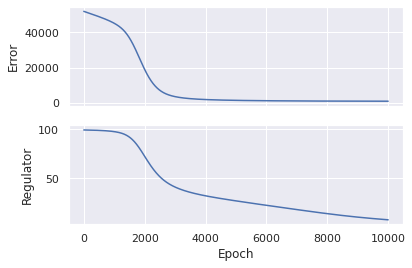

In [26]:
simplex.plot_hist()